# Spiral Problem

This document presents a fictitious problem of learning the length of a spiral;

The equation of the features $x_1$ and $x_2$ and target is given by:
\begin{eqnarray}
    x_1 &=& \theta \cos(\theta) + \epsilon_1 ~~~~~~ x_2 = \theta \sin(\theta) + \epsilon_2 \\
    y &=& \frac{1}{2}\left[ \theta \sqrt{1+\theta^2}+ \sinh^{-1} \theta \right] \nonumber
    \label{eq:spiral}   
\end{eqnarray}
where $x = (x_1, x_2)$ is a point in the Cartesian plane defined by the spiral representing the features $x_1$ and $x_2$, $\theta$ is an independent variable, $\epsilon_i$ ($i \in {1, 2}$) is random noise, and the target value is given by $y$, which is the length of the spiral calculated at a point $x$. This toy model presents some interesting features for our analysis, such as the feature domain over the spiral and the substantial variance of the target value when varying one of the features' coordinates while keeping the other one fixed.

This notebook compares the LIME with MeLIME results. You will need to have LIME installed with you would like to obtain LIME explanations, you can do that by:
> pip install lime

In [1]:
import sys, os
sys.path.append('..')

import pickle
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import HuberRegressor as Linear

# Data - Toy Model Length Spiral
from utils.domain import Spiral


from nnlocallinear import NLS, LLS, NNPredict
from explainers.visualizations.plot_importance import ExplainGraph


# Data spiral

In [2]:
data = Spiral(n_samples=10000, theta_domain=[2*np.pi, 2.5*np.pi], error_x=0.1)

In [3]:
x_train, x_test, y_train, y_test = train_test_split(data.data, data.target, train_size=0.80)

In [4]:
x_train.shape

(8000, 2)

In [5]:
y_train.shape

(8000,)

# Training a MLP Model

In [27]:

def comb(a,b):
    c = []
    for i in a:
        for j in b:
            c.append(np.r_[i,j])
    return np.array(c)

def explain(penalization_thetas=0.0):
    parameters = {
            'es_give_up_after_nepochs': 20
            , 'hidden_size': 100
            , 'num_layers': 4
            , 'n_classification_labels': 0
            , 'penalization_thetas': penalization_thetas
        }

    model = NLS(
            verbose=0
            , es=True
            , gpu=True
            , scale_data=False
            , varying_theta0=False
            , fixed_theta0=False
            , dataloader_workers=0
            , **parameters
        ) 
    model.fit(x_train=x_train, y_train=y_train)
    print('R2: ', metrics.r2_score(y_test, model.predict(x_test)))
    print('MSE: ', metrics.mean_squared_error(y_test, model.predict(x_test)))

    def predict(x):
        return model.predict(x)

    def predict_prob(x):
        return model.predict_proba(x)

    def get_explanation(x_explain, document, num_features=10):
        
        explanation = model.get_thetas(x_pred=x_explain, net_scale=True)
        betas = explanation[2][0]
        
        # Prediction from the model
        prediction = model.predict(x_explain).reshape(-1)
        

        
        return dict(
            chi_names=['x1', 'x2'],
            chi_values=x_explain,
            x_values=x_explain,
            x_names=['x1', 'x2'],
            y_p=predict_prob(x_explain)[0][0],
            y_p_max=100.0,
            y_p_min=0.0,
            y_p_local_model=predict_prob(x_explain)[0][0],
            y_p_local_model_max=None,
            y_p_local_model_min=None,
            error=None,
            importances=betas, 
            diff_convergence_importances=None,
            ind_class_sorted=0,
            class_names= ["lenght"]
        )
    
    x_explain = np.array([[0.0, 8.0]])
    

    nx, ny = (100, 100)
    x = np.linspace(-10, 10, nx)
    xy = comb(x,x)

    x_ = comb(x,x)

    y_p = model.predict(x_)
    y_p = y_p.reshape(-1)
    fig, ax = plt.subplots()
    fig.set_size_inches(8,7)
    cp1 = ax.scatter(x_[:, 0], x_[:, 1], s=50, c=y_p)
    cp2 = ax.scatter(x_explain[:, 0], x_explain[:, 1], s=100, c='red', marker='*')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(cp1, cax=cax)
    cax.set_ylabel('Predicted Length Spiral', fontsize=18)
    cax.tick_params(labelsize=14)
    fig.set_size_inches(7,7)
    ax.set_xlabel('$x_1$', fontsize=20)
    ax.set_ylabel('$x_2$', fontsize=20)
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    print(f'x_explain: {x_explain}')
    print(f'Predict Lenght: {model.predict(np.array([[0.0, 8.0]]))[0][0]:5.4f}')    
    

    explain_dict = get_explanation(x_explain, x_explain, num_features=13)
    explain_dict['y_p']
    fig, axs = ExplainGraph.plot(explain_dict)
    plt.savefig(f'spiral_penalization_thetas_{penalization_thetas}.svg', dpi=300)

R2:  0.8875411375187726
MSE:  61.67707600952238
x_explain: [[0. 8.]]
Predict Lenght: 42.0314


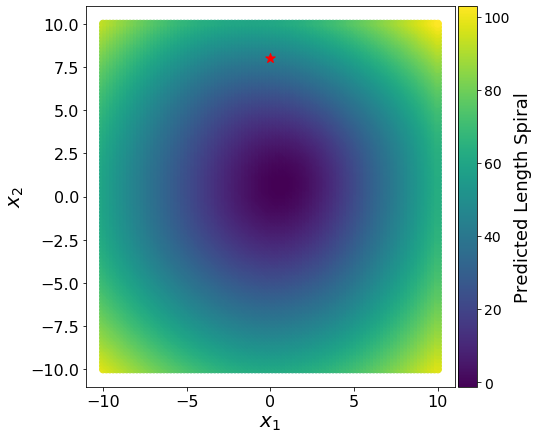

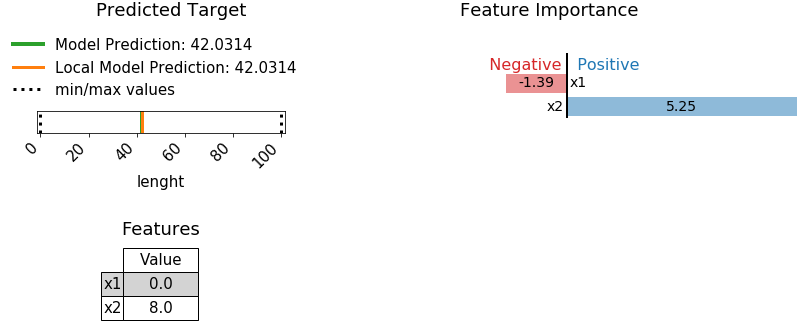

In [28]:
for e in [0.01]:  #, 0.1, 0.2, 0.5, 0.75, 1.0, 2.0]:
    explain(e)

In [15]:
explanation = model.get_thetas(x_pred=x_explain, net_scale=True)
betas = explanation[2][0]

In [16]:
betas

array([-1.2236497,  5.486527 ], dtype=float32)

44.23206

Thank you!